In [85]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, auc, roc_curve

In [86]:
# Import dataset
df = pd.read_csv('../data/features-total-80c4772.csv', index_col='revision_id')
tag_df = pd.read_csv('../data/tag.csv', index_col='id')
df.head()

,isContributorAnonymous,isBot,timeOfDay,dayOfWeek,isMinorEdit,hasPreviousSameContributor,timeSinceLastArticleEdit,timeSinceLastArticleEditBySameContributor,timeSinceFirstArticleEditBySameContributor,revertCount,...,sizeChange,sizeRatio,LZWCompressionRate,KLDOfCharDistribution,commentLength,templateUseFlags,templateUseFifaFlags,templateUsePageLink,templateUseYesNo,tag_id
revision_id,,,,,,,,,,,,,,,,,,,,,
228189784,0.0,0.0,13.0,7.0,0.0,0.0,-1.0,-1.0,-1.0,0.0,...,11909.0,11910.000000,0.513889,1024.000000,34.0,0.0,0.0,0.0,0.0,12
730449352,0.0,0.0,2.0,2.0,0.0,1.0,25.0,25.0,198701.0,0.0,...,504.0,0.003832,0.308994,4.126739,14.0,0.0,0.0,0.0,0.0,12
216224416,0.0,0.0,17.0,6.0,1.0,0.0,7837.0,-1.0,-1.0,0.0,...,78.0,0.003622,0.434896,85.525822,67.0,0.0,0.0,2.0,0.0,12
539338621,0.0,1.0,1.0,4.0,1.0,0.0,2108.0,-1.0,-1.0,0.0,...,-14.0,-0.000196,0.353894,1.286642,152.0,0.0,0.0,0.0,0.0,12
746191686,1.0,0.0,20.0,2.0,0.0,0.0,4077.0,-1.0,-1.0,0.0,...,0.0,0.000048,0.428264,342.595182,10.0,0.0,0.0,0.0,0.0,12


In [87]:
BASELINE_FEATURE_COLUMNS = [
    # Context
    'isContributorAnonymous',
    'commentLength',
    'sizeChange',
    'timeSinceLastArticleEdit',
    'timeOfDay',
    'dayOfWeek',
    'timeSinceFirstArticleEditBySameContributor',
    'timeSinceContributorRevertedBeforeInThatArticle',
    'sizeRatio',
    'hasPreviousSameContributor',
    # Text
    'ratioOfNumericalCharsToAllChars',
    'ratioOfAlphanumericCharsToAllChars',
    'ratioOfUppercaseCharsToAllChars',
    'ratioOfUppercaseCharsToLowercaseChars',
    'lengthOfLongestConsecutiveSequenceOfSingleChar',
    'lengthOfLongestToken',
    'averageRelativeFrequencyOfNewAddedWords',
    'LZWCompressionRate',
    'KLDOfCharDistribution',
    'previousLength',
    # Language
    'vulgarWordFrequencyInComment',
    'vulgarWordFrequencyInTables',
    'vulgarWordImpactInTables',
    'personalPronounFrequencyInComment',
    'personalPronounFrequencyInTable',
    'personalPronounImpactInTable',
    # Ref: Colloquial, high bias
    'superlativeWordFrequencyInComment',
    'superlativeWordFrequencyInTable',
    'superlativeWordImpactInTable',
    'sexualWordFrequencyInComment',
    'sexualWordFrequencyInTables',
    'sexualWordImpactInTables',
    'averageAllBadWordFrequencyInComment',
    'averageAllBadWordFrequencyInTable',
    'averageAllBadWordImpactInTable',
    # Ref: Good words
    'wikiSyntaxElementFrequencyInTable',
    'wikiSyntaxElementImpactInTable',
    'wikiSyntaxElementFrequencyInComment',
    'revertInComment'
]

In [88]:
# Evaluation utils
def plot_confusion_matrix(y_true, y_pred):
    vandalism_count = y_true.value_counts()[True]
    no_vandalism_count = y_true.value_counts()[False]
    cfn_matrix = confusion_matrix(y_true, y_pred)
    cfn_norm_matrix = np.array([[1.0/no_vandalism_count, 1.0/no_vandalism_count], [1.0/vandalism_count, 1.0/vandalism_count]])
    norm_cfn_matrix = cfn_matrix * cfn_norm_matrix
    
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1,2,1)
    sns.heatmap(cfn_matrix, annot=True, fmt="d", linewidths=0.5, ax=ax)
    plt.title('Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')

    ax = fig.add_subplot(1,2,2)
    sns.heatmap(norm_cfn_matrix, linewidths=0.5, annot=True, ax=ax)
    plt.title('Normalized Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
    plt.show()
    
    print('Classification Report')
    classes = ['No Vandalism', 'Vandalism']
    print(classification_report(y_true, y_pred, target_names=classes))
    
def plot_scores(scores):
    print('Cross validation scores')
    scores = list(scores.items())[2:]

    for score in scores:
        sns.lineplot(range(0, 10), score[1], label=score[0])
        plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()

def plot_precision_recall(y_true, y_predict_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_predict_proba)
    average_precision = average_precision_score(y_true, y_predict_proba)
    pr_auc = auc(recall, precision)

    plt.title('Precision-Recall: Average Precision=  %0.2f' % average_precision)
    plt.step(recall, precision, color='b', where='post')
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.show()
    print('Precision / Recall AUC', pr_auc)
    
def plot_roc(y_true, y_predict_proba):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, y_predict_proba)
    roc_auc = auc(false_positive_rate, true_positive_rate)

    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print('Receiver Operation Characteristic AUC', roc_auc)

In [89]:
# Preprocessing utils
class VandalismEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, tag_ids):
        self.tag_ids = tag_ids
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['is_vandalism'] = X.tag_id.isin(self.tag_ids)
        X = X.drop(['tag_id'], axis=1)
        return X

    def fit_transform(self, X, y):
        return self.transform(X)
    
class RevisionGrouper(BaseEstimator, TransformerMixin):        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.groupby(X.index).apply(self._vandalism_revision_or_first)
        return X

    def fit_transform(self, X, y=None):
        return self.transform(X)
    
    def _vandalism_revision_or_first(self, group):
        vandalism_revisions = group.loc[group['is_vandalism'] == True]
        return vandalism_revisions.iloc[0] if len(vandalism_revisions) > 0 else group.iloc[0]

class FeatureSelector(BaseEstimator, TransformerMixin):        
    def __init__(self, columns=None):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.columns != None:
            # Do not remove 'is_vandalism'
            self.columns.append('is_vandalism')
            X = X[self.columns]
        return X


    
    def fit_transform(self, X, y=None):
        return self.transform(X)

## Preprocessing

In [90]:
def preprocessing(features):
    feature_columns = None
    
    if features == 'baseline':
        feature_columns = BASELINE_FEATURE_COLUMNS

    preprocess_pipeline = Pipeline([
        ('vandalism_encoder', VandalismEncoder([1, 2, 3, 4, 5])),
        ('revision_grouper', RevisionGrouper()),
        ('feature_selector', FeatureSelector(feature_columns))
    ])

    return preprocess_pipeline.transform(df)
    
widget = interactive(preprocessing, features=['all', 'baseline'])
display(widget)

interactive(children=(Dropdown(description='features', options=('all', 'baseline'), value='all'), Output()), _…

In [92]:
processed_df = widget.result
print('Feature config:', widget.kwargs['features'], ', Features after preprocessing:', len(processed_df.columns))

Feature config: baseline , Features after preprocessing: 40


In [93]:
# X, y split
X = processed_df.drop(['is_vandalism'], axis=1)
y = processed_df['is_vandalism']

In [94]:
# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print('X train', X_train.shape)
print('y train', y_train.shape)
print('X test', X_test.shape)
print('y test', y_test.shape)

X train (3723, 39)
y train (3723,)
X test (1242, 39)
y test (1242,)


## Grid search model parameters

In [95]:
# Grid search model params
parameters = [{
    'n_estimators': [250],
    'class_weight': ['balanced', {0:1,1:1}]
}]

grid_search = GridSearchCV(RandomForestClassifier(),
                           parameters, 
                           scoring=['f1', 'precision', 'recall', 'roc_auc'],
                           refit='f1',
                           cv=10)
grid_search.fit(X_train, y_train)

params = grid_search.best_params_
print('Best params', grid_search.best_params_)
print('Best score', grid_search.best_score_)

Best params {'class_weight': {0: 1, 1: 1}, 'n_estimators': 250}
Best score 0.6094137714731013


## Train: Cross evaluate model using best parameters

In [96]:
# Train scores & predictions
clf = RandomForestClassifier(n_estimators=params['n_estimators'], class_weight=params['class_weight'], n_jobs=-1)
train_scores = cross_validate(clf, X_train, y_train,
                        scoring=['f1', 'precision', 'recall', 'roc_auc', 'accuracy'],
                        cv=10, n_jobs=-1, return_train_score=False)

y_train_predict = cross_val_predict(clf, X_train, y_train, cv=10, n_jobs=-1, method='predict')
y_train_predict_proba = cross_val_predict(clf, X_train, y_train, cv=10, n_jobs=-1, method='predict_proba')

Cross validation scores


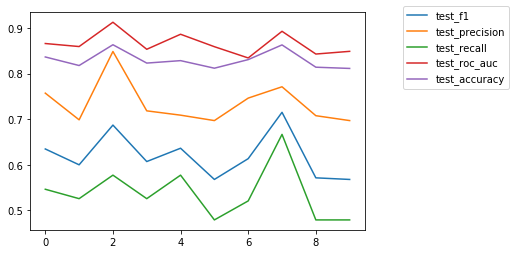

In [97]:
plot_scores(train_scores)

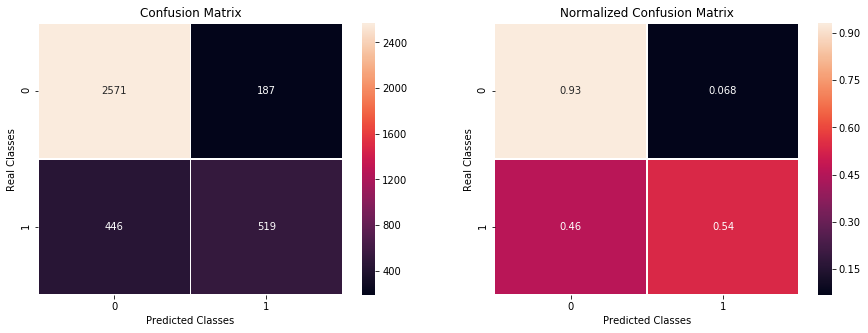

Classification Report
              precision    recall  f1-score   support

No Vandalism       0.85      0.93      0.89      2758
   Vandalism       0.74      0.54      0.62       965

 avg / total       0.82      0.83      0.82      3723



In [98]:
plot_confusion_matrix(y_train, y_train_predict)

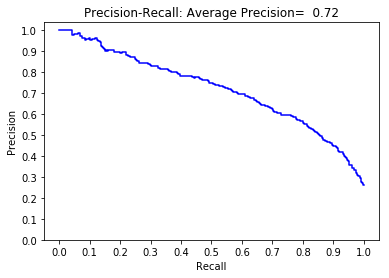

Precision / Recall AUC 0.7213727035141133


In [99]:
plot_precision_recall(y_train, y_train_predict_proba[:, 1])

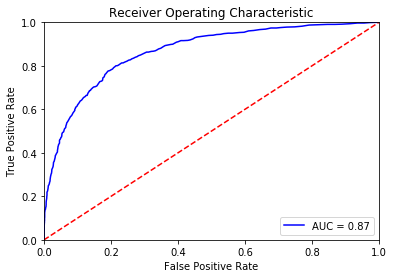

Receiver Operation Characteristic AUC 0.8653234866445988


In [100]:
plot_roc(y_train, y_train_predict_proba[:, 1])

## Test: Test model on final test dataset

In [101]:
clf = RandomForestClassifier(n_estimators=params['n_estimators'], class_weight=params['class_weight'], n_jobs=-1)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 1},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=250, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [102]:
y_test_predict = clf.predict(X_test)
y_test_predict_proba = clf.predict_proba(X_test)

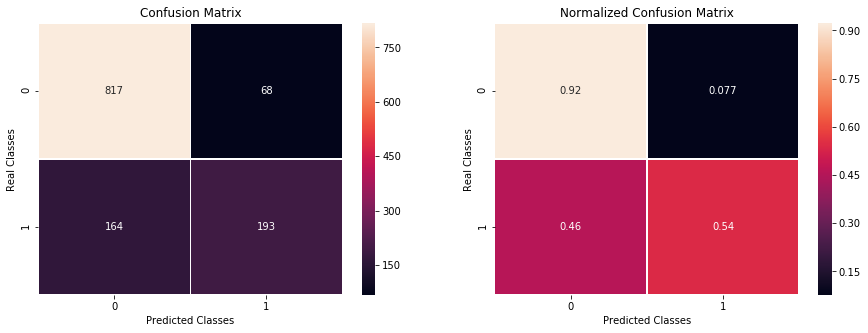

Classification Report
              precision    recall  f1-score   support

No Vandalism       0.83      0.92      0.88       885
   Vandalism       0.74      0.54      0.62       357

 avg / total       0.81      0.81      0.80      1242



In [103]:
plot_confusion_matrix(y_test, y_test_predict)

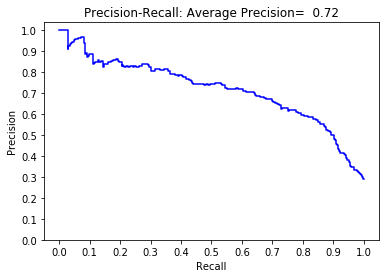

Precision / Recall AUC 0.7176485956973172


In [104]:
plot_precision_recall(y_test, y_test_predict_proba[:, 1])

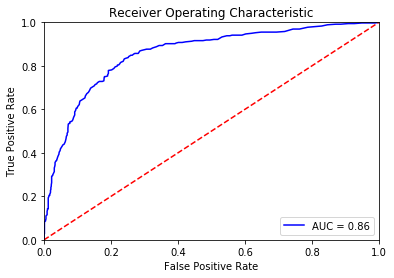

Receiver Operation Characteristic AUC 0.857202994192027


In [105]:
plot_roc(y_test, y_test_predict_proba[:, 1])